# Credit Card Fraud Challenge

Karim Amjar, Cédric Bailly, Thomas Jalabert, Thomas Mahiout, Vincent Raybaud, Tiffanie Schreyeck

Notebook source : https://www.kaggle.com/currie32/predicting-fraud-with-tensorflow

L'objectif de ce notebook est d'essayer de prédire si une transaction par carte bancaire est une fraude. On utilisera la librairie *tensorflow* pour construire le modèle prédictif, et t-SNE pour visualiser l'ensemble des données.

Il se décline en cinq parties :
 1. Eploration des données
 2. Préparation des données
 3. Réseau de neurones
 4. Entraînement du réseau
 5. Visualisation des données

## Sommaire

- [Credit Card Fraud Challenge](#credit-card-fraud-challenge)
  * [Exploration des données](#exploration-des-donn-es)
    + [Matrice de corrélation](#matrice-de-corr-lation)
    + [Identifier les fraudes grâce au temps](#identifier-les-fraudes-gr-ce-au-temps)
    + [Distinguer les classes grâce au montant](#distinguer-les-classes-gr-ce-au-montant)
    + [Distinguer les classes grâces aux $V_x$](#distinguer-les-classes-gr-ces-aux--v-x-)
  * [Préparation des données pour l'entrainement](#pr-paration-des-donn-es-pour-l-entrainement)
    + [Préparation du réseau](#pr-paration-du-r-seau)
  * [Le réseau de neurones](#le-r-seau-de-neurones)
    + [L'entraînement](#l-entra-nement)
  * [Entrainement sans drop d'attributs](#entrainement-sans-drop-d-attributs)
    + [Conclusion sur les choix de l'entrainement](#conclusion-sur-les-choix-de-l-entrainement)
  * [Visualisation des données avec l'algorithme t-SNE](#visualisation-des-donn-es-avec-l-algorithme-t-sne)
    + [Visualisation des données originales](#visualisation-des-donn-es-originales)
    + [Visualisation des données modifiées](#visualisation-des-donn-es-modifi-es)

## Exploration des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf # machine learning
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.gridspec as gridspec
import seaborn as sns # visualisation stats
%matplotlib inline

In [2]:
df = pd.read_csv("creditcard.csv") # On charge le fichier en mémoire
df_without_drop = df.copy();
df.head() # affiche les 5 premières lignes

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Chaque instance représente une transaction qui est consituée de 31 attributs. 
- Il y a un attribut $Time$ qui représente le temps, en seconde, écoulé depuis la première transaction. Environ deux jours séparent la première transaction de la dernière.
- Un attribut $Amount$ qui représente le montant de la transaction.
- Un attribut $Class$ qui permet de savoir si la transaction est frauduleuse ou non. Il vaut `1` dans le cas d'une fraude, `0` sinon.
- 28 autres attributs classés de $V1$ à $V28$.

Les attributs $Vx$ ne sont pas explicitement définis par la base de données mais sont des éléments constitutifs de la transaction. L'information est sûrement cachée à des fin de protection des données bancaires. De plus, un traitement supplémentaire a peut-être été effectué sur ces données pour que l'on ne connaisse pas leur vraie fonction.

In [3]:
df.isnull().sum() # nombre d'éléments "null"

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Il n'y a aucune donnée manquante dans ce dataset. Nous allons commencer par chercher s'l existe d'éventuelles corrélations entre les différents attributs.

### Matrice de corrélation

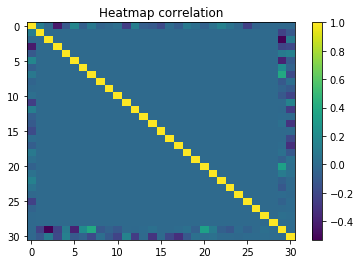

In [4]:
df_corr = df.corr()
plt.title('Heatmap correlation')
plt.imshow(df_corr, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

On remarque certaines corrélations entre l'heure de la transaction et la plupart des autres attributs et de même pour le montant de la transaction (les éléments aux extrémités de la carte). 
Cependant la très grande majorité des autres attributs ne sont pas corrélés entre eux.

### Identifier les fraudes grâce au temps

In [5]:
print ("Fraud:\n")
print (df.Time[df.Class == 1].describe())
print ()
print ("Normal:")
print (df.Time[df.Class == 0].describe())

Fraud:

count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64

Normal:
count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64


Ici, on cherche à comparer les deux classes de données. Il y a peut-être une différence sur la répartition dans le temps entre une fraude et une transaction normale.
Il n'y a pas de moyen de distinguer les deux classes par ce biais.
On remarque qu'il y a seulement $492$ fraudes pour $284315 + 492$ transactions dans cet ensemble de données ($0.172\%$).

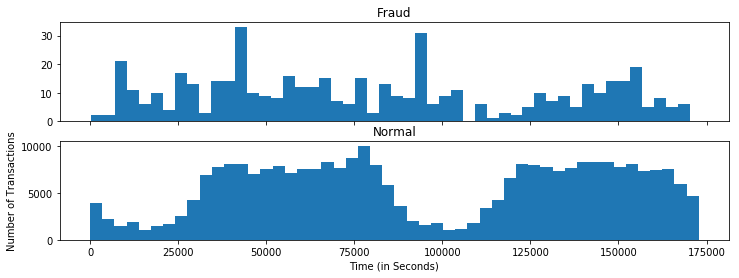

In [6]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(df.Time[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Time[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

Ici, on cherche à identifier si les transactions en fraudes se passent à des moments particuliers de la journée. Ici on voit bien que les transactions normales diminuent progressivement durant la nuit. Mais les fraudes ne sont pas atteintes par cette baisse.

> You could argue that fraudulent transactions are more uniformly distributed, while normal transactions have a cyclical distribution.

Ici l'auteur estime que les transactions frauduleuses suivent une loi uniformément distribuée alors que les transactions normales suivent une distribution cyclique.

### Distinguer les classes grâce au montant

In [7]:
print ("Fraud")
print (df.Amount[df.Class == 1].describe())
print ()
print ("Normal")
print (df.Amount[df.Class == 0].describe())

Fraud
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Normal
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


Ici on essaie de savoir s'il y a une différence significative entre les montants des deux types de transactions. Cet attribut ne permet cependant pas de déterminer la classe d'une transaction.

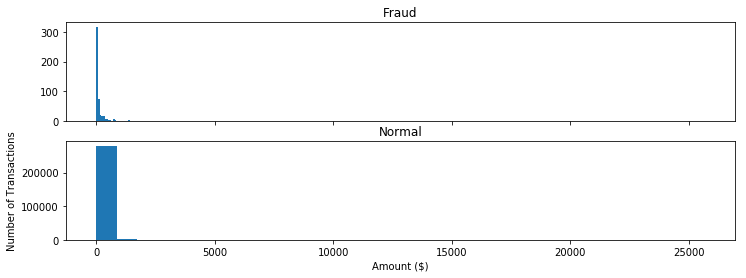

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 30

ax1.hist(df.Amount[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Amount[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
#plt.yscale('log')
plt.show()


Même si le nombre de transactions normales est beaucoup plus élevé que les fraudes, la répartition globale du montant est la même, c'est-à-dire que la grande majorité des transactions ont des petits montants.

In [9]:
df['Amount_max_fraud'] = 1
df.loc[df.Amount <= 2125.87, 'Amount_max_fraud'] = 0
df['Amount_max_fraud'].sum()

603

Ici l'auteur ajoute une colonne à la DataFrame, qui vaut 1 si le montant de la transaction est supérieur à la plus grande fraude. Seulement $603$ transactions ont un montant supérieur ($0.212\%$).

### Distinguer les classes grâces aux $V_x$

On va maintenant essayer d'analyser les élements anonymes $V_x$. En effet, bien que ces données aient été cryptées par l'entreprise, si on observe une distribution différente entre les deux types de transactions (normales vs. frauduleuses) cela nous indiquera quels élements sont pertinents à analyser (pour l'entreprise) afin de détecter une fraude.

In [10]:
# Extraction des élements anonymes seulement
v_features = df.ix[:,1:29].columns

C:\Users\MiniKochi\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


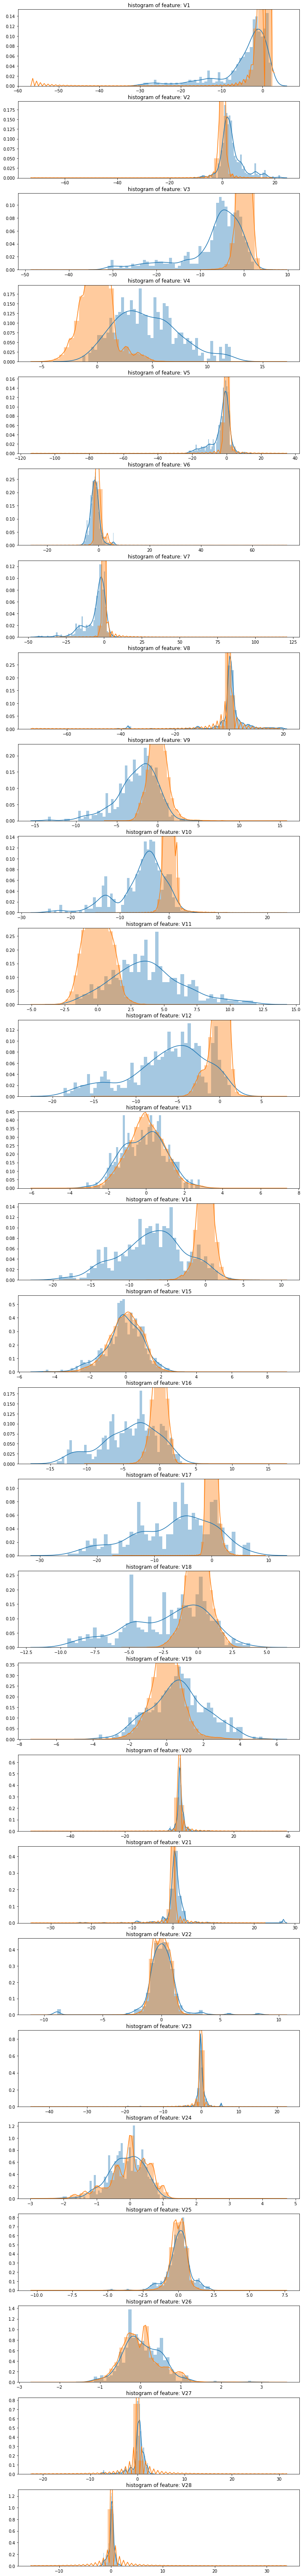

In [11]:
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(df[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50) # Fraude en bleu
    sns.distplot(df[cn][df.Class == 0], bins=50) # Transactions normales en vert
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

Ces graphiques sont beaucoup plus intéressants que les précédents. En effet, sur certains d'entre eux on distingue clairement deux distributions différentes, en particulier sur $V1, V2, V3, V4, V9, V10, V11, V12, V14, V16, V17, V18$ et $V19$.

Même si un seul de ces attributs ne permettrait pas d'identifier si la transaction est une fraude, une combinaison de chacun de ces attributs rend le travail de classification envisageable/possible.

## Préparation des données pour l'entrainement

In [12]:
#Drop all of the features that have very similar distributions between the two types of transactions.
df = df.drop(['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8'], axis =1)

Les autres attributs ne permettent pas de différencier l'une de l'autre classe. Ces attributs peuvent être considérés comme du bruit lors de l'entrainement du réseau de neurones. Entrainer le réseau sur ces attributs peut nuire à son efficacité et rendre l'entrainement significativement plus long. Nous décidons de supprimer ces attributs pour préparer les données à l'entrainement du réseau.

In [13]:
#Based on the plots above, these features are created to identify values where fraudulent transaction are more common.
df['V1_'] = df.V1.map(lambda x: 1 if x < -3 else 0)
df['V2_'] = df.V2.map(lambda x: 1 if x > 2.5 else 0)
df['V3_'] = df.V3.map(lambda x: 1 if x < -4 else 0)
df['V4_'] = df.V4.map(lambda x: 1 if x > 2.5 else 0)
df['V5_'] = df.V5.map(lambda x: 1 if x < -4.5 else 0)
df['V6_'] = df.V6.map(lambda x: 1 if x < -2.5 else 0)
df['V7_'] = df.V7.map(lambda x: 1 if x < -3 else 0)
df['V9_'] = df.V9.map(lambda x: 1 if x < -2 else 0)
df['V10_'] = df.V10.map(lambda x: 1 if x < -2.5 else 0)
df['V11_'] = df.V11.map(lambda x: 1 if x > 2 else 0)
df['V12_'] = df.V12.map(lambda x: 1 if x < -2 else 0)
df['V14_'] = df.V14.map(lambda x: 1 if x < -2.5 else 0)
df['V16_'] = df.V16.map(lambda x: 1 if x < -2 else 0)
df['V17_'] = df.V17.map(lambda x: 1 if x < -2 else 0)
df['V18_'] = df.V18.map(lambda x: 1 if x < -2 else 0)
df['V19_'] = df.V19.map(lambda x: 1 if x > 1.5 else 0)
df['V21_'] = df.V21.map(lambda x: 1 if x > 0.6 else 0)

De plus, afin d'améliorer la détection de transactions frauduleuses par le réseau de neurones, on ajoute $17$ nouveaux attributs, basés sur les graphiques ci-dessus. Pour les créer, l'auteur utilise la fonction **`percentile()`** de la librairie Numpy. Il ne pouvait pas vraiment utiliser d'autre séparation plus "mathématique". En effet, il aurait du faire un échantillonage car il y a un déséquillibre trop important entre le nombre de transactions normales et frauduleuses.

On choisit donc de séparer de façon presque visuel en deux parties en attribuant "$1$" aux valeurs qui devrait majoritairement correspondre à une fraude et "$0$" s'il s'agit d'une transaction normale. Ajouter ce nouvel attribut devrait faciliter la classification des attributs lors de l'apprentissage.

In [14]:
#Create a new feature for normal (non-fraudulent) transactions.
df.loc[df.Class == 0, 'Normal'] = 1
df.loc[df.Class == 1, 'Normal'] = 0

Ici l'auteur ajoute une colonne appelée $Normal$, qui vaut $1$ si la transaction est normale, et $0$ si elle est frauduleuse.
Cette colonne est donc "l'opposée" de la colonne '$Class$.

In [15]:
#Rename 'Class' to 'Fraud'.
df = df.rename(columns={'Class': 'Fraud'})

In [16]:
print(df.Normal.value_counts())
print()
print(df.Fraud.value_counts())

1.0    284315
0.0       492
Name: Normal, dtype: int64

0    284315
1       492
Name: Fraud, dtype: int64


On rappelle le nombre de fraudes et le nombre total de transactions. Les fraudes représentent $0.172\%$ des données.

La DataFrame contient maintenant $39$ colonnes :

In [17]:
#pd.set_option("display.max_columns",101)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V9,V10,...,V10_,V11_,V12_,V14_,V16_,V17_,V18_,V19_,V21_,Normal
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,...,0,0,0,0,0,0,0,0,0,1.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,...,0,0,0,0,0,0,0,0,0,1.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,...,0,0,0,0,1,0,0,0,0,1.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,...,0,0,0,0,0,0,0,0,0,1.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,...,0,0,0,0,0,0,0,0,0,1.0


In [18]:
#Create dataframes of only Fraud and Normal transactions.
Fraud = df[df.Fraud == 1]
Normal = df[df.Normal == 1]

On crée deux nouvelles DataFrame qui contiennent uniquement les fraudes, et uniquement les transactions normales.

### Préparation du réseau

In [19]:
# Set X_train equal to 80% of the fraudulent transactions.
X_train = Fraud.sample(frac=0.8)
count_Frauds = len(X_train)

# Add 80% of the normal transactions to X_train.
X_train = pd.concat([X_train, Normal.sample(frac = 0.8)], axis = 0)

# X_test contains all the transaction not in X_train.
X_test = df.loc[~df.index.isin(X_train.index)]

L'ensemble de training du réseau de neurones représente $80\%$ des données ($80\%$ des fraudes et $80\%$ des transactions normales).
On place les $20\%$ restants dans l'ensemble de test.

In [20]:
#Shuffle the dataframes so that the training is done in a random order.
X_train = shuffle(X_train)
X_test = shuffle(X_test)

On mélange aléatoirement les données pour que notre réseau pour mélanger les fraudes et les transactions normales. (L'algorithme de descente de gradient donne plus de poids aux premières itérations).

In [21]:
#Add our target features to y_train and y_test.
y_train = X_train.Fraud
y_train = pd.concat([y_train, X_train.Normal], axis=1)

y_test = X_test.Fraud
y_test = pd.concat([y_test, X_test.Normal], axis=1)

In [22]:
#Drop target features from X_train and X_test.
X_train = X_train.drop(['Fraud','Normal'], axis = 1)
X_test = X_test.drop(['Fraud','Normal'], axis = 1)

On crée deux DataFrame contenant les labels de nos ensembles d'entraînement et de test. Dans la DataFrame destinée à l'entraînement, on enlève ensuite les attributs indiquant la classe de la transaction, car c'est la classe qui permet de vérifier l'efficacité de l'entrainement.

In [23]:
#Check to ensure all of the training/testing dataframes are of the correct length
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

227846
227846
56961
56961


In [24]:
'''
Due to the imbalance in the data, ratio will act as an equal weighting system for our model.
By dividing the number of transactions by those that are fraudulent, ratio will equal the value that when multiplied
by the number of fraudulent transactions will equal the number of normal transaction.
Simply put: # of fraud * ratio = # of normal
'''
ratio = len(X_train)/count_Frauds

y_train.Fraud *= ratio
y_test.Fraud *= ratio

Nous calculons le ratio entre le nombre de transactions normales et le nombre de fraudes (environ égal à $578$).
On multiplie les labels des fraudes par ce ratio. Ainsi, les transactions normales auront les labels [Fraud, Normal] = [0, 1], et les fraudes auront comme labels [Fraud, Normal] = [578, 0].

Cela forcera le réseau de neurones à donner autant de poids à l'ensemble des fraudes qu'à l'ensemble des transactions normales, malgré la faible proportion de fraudes.

In [25]:
#Names of all of the features in X_train.
features = X_train.columns.values

#Transform each feature in features so that it has a mean of 0 and standard deviation of 1; 
#this helps with training the neural network.
for feature in features:
    mean, std = df[feature].mean(), df[feature].std()
    X_train.loc[:, feature] = (X_train[feature] - mean) / std
    X_test.loc[:, feature] = (X_test[feature] - mean) / std

On normalise les attributs (pas les labels) pour faciliter l'entraînement du réseau de neurones. En effet, un attribut qui s'étale sur un intervalle plus grand risque d'être considéré plus important que les autres par le réseau. De plus, on centre autour de $0$ pour que les valeurs soient plus petites. Cela améliore la vitesse de convergence de l'algorithme.

## Le réseau de neurones

In [26]:
# Split the testing data into validation and testing sets
split = int(len(y_test)/2)

inputX = X_train.as_matrix()
inputY = y_train.as_matrix()
inputX_valid = X_test.as_matrix()[:split]
inputY_valid = y_test.as_matrix()[:split]
inputX_test = X_test.as_matrix()[split:]
inputY_test = y_test.as_matrix()[split:]

Ici l'ensemble de test est découpé en deux parties à peu près de même taille. Notre ensemble de données est maintenant scindé en trois parties :
 - l'ensemble d'**entraînement** qui permettra au réseau de neurones de construire un modèle de prédiction
 - l'ensemble de **validation**, sur lequel le réseau ne s'entraîne pas. Cet ensemble permet de vérifier que le réseau n'est pas en *suraprentissage*. Si la précision augmente pendant l'entraînement, alors que la précision sur l'ensemble de validation décroît ou stagne, alors le réseau est en surapprentissage et on devrait arrêter l'entraînement.  
 En plus d'une perte de temps, un surapprentissage aurait pour conséquence une mauvaise généralisation de la part du modèle de prédiction.
 - l'ensemble de **test** permet de tester l'efficacité de notre modèle, à la fin de son entraînement.

In [27]:
# Number of input nodes.
input_nodes = 37

# Multiplier maintains a fixed ratio of nodes between each layer.
mulitplier = 1.5

# Number of nodes in each hidden layer
hidden_nodes1 = 18
hidden_nodes2 = round(hidden_nodes1 * mulitplier)
hidden_nodes3 = round(hidden_nodes2 * mulitplier)

# Percent of nodes to keep during dropout.
pkeep = tf.placeholder(tf.float32)

Afin de réaliser l'entrainement de notre réseau de neurones, nous choisissons un nombre d'inputs correspondant à notre nombre d'arguments.

L'architecture du réseau, c'est-à dire le nombre de couches cachées et le nombre de noeuds dans chaque couche, est un choix de l'auteur. Il a probablement effectué plusieurs tests sur des structures usuelles, afin d'optimiser l'architecture.

**`pkeep`** sera la proportion de noeuds à garder pendant le **`dropout`**. C'est une technique permettant d'éviter le suraprentissage, en forçant le réseau à "oublier" certains neurones (choisis aléatoirement) temporairement.

In [28]:
# input
x = tf.placeholder(tf.float32, [None, input_nodes])

# layer 1
W1 = tf.Variable(tf.truncated_normal([input_nodes, hidden_nodes1], stddev = 0.15))
b1 = tf.Variable(tf.zeros([hidden_nodes1]))
y1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)

# layer 2
W2 = tf.Variable(tf.truncated_normal([hidden_nodes1, hidden_nodes2], stddev = 0.15))
b2 = tf.Variable(tf.zeros([hidden_nodes2]))
y2 = tf.nn.sigmoid(tf.matmul(y1, W2) + b2)

# layer 3
W3 = tf.Variable(tf.truncated_normal([hidden_nodes2, hidden_nodes3], stddev = 0.15)) 
b3 = tf.Variable(tf.zeros([hidden_nodes3]))
y3 = tf.nn.sigmoid(tf.matmul(y2, W3) + b3)
y3 = tf.nn.dropout(y3, pkeep)

# layer 4
W4 = tf.Variable(tf.truncated_normal([hidden_nodes3, 2], stddev = 0.15)) 
b4 = tf.Variable(tf.zeros([2]))
y4 = tf.nn.softmax(tf.matmul(y3, W4) + b4)

# output
y = y4
y_ = tf.placeholder(tf.float32, [None, 2])

Nous configurons chaque couche du réseau pour qu'elle utilise le résultat de la couche précédente.

Du bruit est ajouté à chaque couche, pour diminuer le risque que l'algorithme de rétropropagation (basé sur la descente de gradient), stagne puis s'arrête sur minimum local.

La fonction **`sigmoid`** après chaque couche est la fonction qui calcule une sortie, à partir des valeurs fournies par les neurones de la couche précédente. Elle est très souvent utilisée dans les réseaux de neurones, car en plus d'être différentiable (donc permet la descente de gradient), elle produit un résultat compris entre $0$ et $1$, ce qui peut être interprété comme une probabilité si besoin.

Le **`dropout`** est effectué à la couche 3.

La fonction **`softmax`** appliquée à la dernière couche permet de normaliser le vecteur de sortie, afin de pouvoir interpréter le résultat comme les probabilités d'appartenir à nos classes de transactions.

In [29]:
# Parameters
training_epochs = 10 # should be 2000, it will timeout when uploading
training_dropout = 0.9
display_step = 1 # les détails de l'entraînement seront affichés à chaque pas
n_samples = y_train.shape[0]
batch_size = 2048
learning_rate = 0.005

Nous choisissons ici minutieusement les paramètres de notre modèle. En effet ces paramètres vont déterminer le temps d'entraînement de notre réseau et son efficacité.
 - un **epoch** est le nombre de fois que le réseau parcourera toutes les données de l'ensemble d'entraînement.
 - **`training_dropout`** correspond au paramètre **`pkeep`** déclaré plus tôt : $90\%$ des noeuds seront gardés lors d'un **`dropout`**.
 - **`batch_size`** est le nombre de données qui vont être propagées dans le réseau à chaque itération. Il ne doit pas être trop petit, sinon l'estimation du gradient à chaque itération sera trop grossière. S'il est trop grand, le réseau sera très lent.
 - le **`learning_rate`** peut être interprété comme l'adaptabilité aux outliers. Si le learning rate est petit, le réseau considèrera toute valeur légèrement différente comme un outlier, et l'ignorera. L'entraînement peut être très long, surtout si les données d'une même classe sont disparates. Au contraire si le learning rate est très grand, un outlier risque d'être considéré comme représentatif de la classe, et la classification peut être inefficace.

In [30]:
# Cost function: Cross Entropy
cost = -tf.reduce_sum(y_ * tf.log(y))

# We will optimize our model via AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Correct prediction if the most likely value (Fraud or Normal) from softmax equals the target value.
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Pendant l'entraînement d'un réseau de neurones, la fonction *coût* (parfois appelée *loss*) permet de quantifier la précision du modèle, à chaque itération. Pour cela on compare la sortie du réseau avec la valeur attendue. On pourrait par exemple utiliser la fonction quadratique (moindres carrés). Dans la plupart des cas, la fonction *cost* diminue fortement, puis se stabilise et tend vers une valeur minimale au cours de l'entraînement. Cependant si la première sortie du réseau est une très mauvaise prédiction, la fonction *cost* va prendre beaucoup de temps à décroître. En utilisant une fonction avec un logarithme, les poids seront mieux ajustés et ce problème sera résolu.

Dans cette partie, l'objectif est d'optimiser notre modèle d'entrainement à l'aide de la classe AdamOptimizer. Cette classe est une sous-classe d'Optimizer qui fournit des méthodes permettant d'optimiser un certain nombre d'algorithmes de gradients tels que GradientDescent ou Adagrad.

En ce qui nous concerne, nous utilisons la méthode minimize() avec comme objectif la minimisation du coût de calcul de notre réseau de neurones. Dans notre cas, cette méthode d'optimisation peut être appliquée car les observations dont nous disposons sont bruitées.

Par ailleurs, nous considérons le cas où la valeur avec la plus grande probabilité est effectivement égale à la valeur souhaitée. Et dans ce cas, nous corrigeons la prédiction obtenue par notre modèle afin d'améliorer la précision de celui-ci.


### L'entraînement

Dans la prochaine cellule qui contient l'entraînement du réseau de neurones, nous mettrons des commentaires (en français) directement dans le code, pour une meilleure compréhension.

In [31]:

## Ces 4 vecteurs sont mis à jour à chaque itération (à chaque batch) ;
## ils permettront de tracer les détails de l'entraînement à la fin de celui-ci.
## Ils contiennent respectivement :
## la précision sur l'ensemble entraînement, le coût de l'entraînement,
## la précision sur l'ensemble de validation, et le coût sur l'ensemble validation

accuracy_summary = []
cost_summary = []
valid_accuracy_summary = []
valid_cost_summary = []

## A chaque itération, on vérifie si on est pas en surapprentissage
## On stoppe l'entraînement si c'est le cas

stop_early = 0 # To keep track of the number of epochs before early stopping

# Save the best weights so that they can be used to make the final predictions
checkpoint = "./best_model.ckpt"
saver = tf.train.Saver(max_to_keep=1)

# Initialize variables and tensorflow session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(training_epochs):  
        for batch in range(int(n_samples/batch_size)): 
            batch_x = inputX[batch*batch_size : (1+batch)*batch_size]
            batch_y = inputY[batch*batch_size : (1+batch)*batch_size]

            ## Une itération d'entraînement = un passage dans le réseau de neurones, avec 2048 données :
            sess.run([optimizer], feed_dict={x: batch_x, 
                                             y_: batch_y,
                                             pkeep: training_dropout})

        # Display logs after every 1 epochs
        if (epoch) % display_step == 0:
            train_accuracy, newCost = sess.run([accuracy, cost], feed_dict={x: inputX,
                                                                            y_: inputY,
                                                                            pkeep: training_dropout})

            valid_accuracy, valid_newCost = sess.run([accuracy, cost], feed_dict={x: inputX_valid,
                                                                                  y_: inputY_valid,
                                                                                  pkeep: 1})

            print ("Epoch:", epoch,
                   "Acc =", "{:.5f}".format(train_accuracy),
                   "Cost =", "{:.5f}".format(newCost),
                   "Valid_Acc =", "{:.5f}".format(valid_accuracy),
                   "Valid_Cost = ", "{:.5f}".format(valid_newCost))

            # Save the weights if these conditions are met.
            #if epoch > 0 and valid_accuracy > max(valid_accuracy_summary) and valid_accuracy > 0.999:
            saver.save(sess, checkpoint)

            # Record the results of the model
            accuracy_summary.append(train_accuracy)
            cost_summary.append(newCost)
            valid_accuracy_summary.append(valid_accuracy)
            valid_cost_summary.append(valid_newCost)

            # If the model does not improve after 15 logs, stop the training.
            if valid_accuracy < max(valid_accuracy_summary) and epoch > 100:
                stop_early += 1
                if stop_early == 15:
                    break
            else:
                stop_early = 0

    print()
    print("Optimization Finished!")
    print()

with tf.Session() as sess:
    # Load the best weights and show its results
    saver.restore(sess, checkpoint)
    training_accuracy = sess.run(accuracy, feed_dict={x: inputX, y_: inputY, pkeep: training_dropout})
    validation_accuracy = sess.run(accuracy, feed_dict={x: inputX_valid, y_: inputY_valid, pkeep: 1})

    print("Results using the best Valid_Acc:")
    print()
    print("Training Accuracy =", training_accuracy)
    print("Validation Accuracy =", validation_accuracy)

Epoch: 0 Acc = 0.95984 Cost = 70275.17969 Valid_Acc = 0.96001 Valid_Cost =  9399.92773
Epoch: 1 Acc = 0.94509 Cost = 70119.85938 Valid_Acc = 0.94529 Valid_Cost =  8254.61133
Epoch: 2 Acc = 0.94630 Cost = 66649.25000 Valid_Acc = 0.94593 Valid_Cost =  8626.57617
Epoch: 3 Acc = 0.95240 Cost = 65470.20312 Valid_Acc = 0.95260 Valid_Cost =  8647.75488
Epoch: 4 Acc = 0.94854 Cost = 65170.09375 Valid_Acc = 0.94821 Valid_Cost =  8671.29883
Epoch: 5 Acc = 0.95528 Cost = 61498.75781 Valid_Acc = 0.95565 Valid_Cost =  8498.64355
Epoch: 6 Acc = 0.95328 Cost = 59065.35938 Valid_Acc = 0.95369 Valid_Cost =  8788.49609
Epoch: 7 Acc = 0.95291 Cost = 57170.86719 Valid_Acc = 0.95330 Valid_Cost =  8829.85645
Epoch: 8 Acc = 0.95519 Cost = 56259.07031 Valid_Acc = 0.95674 Valid_Cost =  8818.19727
Epoch: 9 Acc = 0.95783 Cost = 54171.49609 Valid_Acc = 0.95920 Valid_Cost =  9195.87305

Optimization Finished!

INFO:tensorflow:Restoring parameters from ./best_model.ckpt
Results using the best Valid_Acc:

Training A

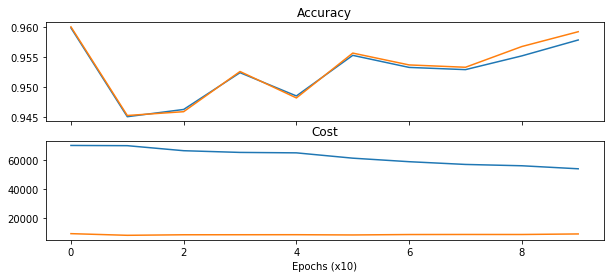

In [32]:
# Plot the accuracy and cost summaries 
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,4))

ax1.plot(accuracy_summary) # blue
ax1.plot(valid_accuracy_summary) # green
ax1.set_title('Accuracy')

ax2.plot(cost_summary)
ax2.plot(valid_cost_summary)
ax2.set_title('Cost')

plt.xlabel('Epochs (x10)')
plt.show()

In [33]:
# Find the predicted values, then use them to build a confusion matrix
predicted = tf.argmax(y, 1)
with tf.Session() as sess:
#    # Load the best weights
    saver.restore(sess, checkpoint)
    testing_predictions, testing_accuracy = sess.run([predicted, accuracy], 
                                                     feed_dict={x: inputX_test, y_:inputY_test, pkeep: 1})
#    
#    print("F1-Score =", f1_score(inputY_test[:,1], testing_predictions))
    print("Testing Accuracy =", testing_accuracy)
    print()
    c = confusion_matrix(inputY_test[:,1], testing_predictions)
c

INFO:tensorflow:Restoring parameters from ./best_model.ckpt
Testing Accuracy = 0.959763



array([[   39,     4],
       [ 1142, 27296]], dtype=int64)

Les résultats de l'entrainement changent à chaque utilisation du programme du fait que les données d'entrainement et les données utilisées pour tester la précision du réseau de neurones changent à chaque exécution. De ce fait nos conclusions ne se basent pas sur les résultats affichés mais sur un ensemble d'exécution limité (une dizaine en l'occurence). La précision générale est toujours stable vers $98.5\%$.

En moyenne, La matrice de confusion nous indique en général $\approx88\%$ de bonne classification pour les fraudes ($\pm5\%$ de marge d'erreur) et un peu moins de $99\%$ pour les transactions normales. La précision sur la classification des transactions frauduleuses varie énormément du fait qu'on utilise que environ $10\%$ du set original pour ce test (mais indépendant des données d'entrainement) et cela est très peu ($40$-$60$ valeurs) d'où la forte variance.

Encore une fois le déséquilibre entre le nombre de transactions normales et frauduleuses est préjudiciables du fait qu'on a ici beaucoup de mal à évaluer les performances de notre réseau de neurones.

## Entrainement sans drop d'attributs

Nous avons décidé de rajouter une partie où l'on entraîne le réseau de neuronnes sans pré-traiter les données, afin de montrer que la décision de l'auteur de drop les features qui n'apportaient pas d'information significatives pour classifier selon le type de transaction n'affecte pas la précision de la classification. On peut même s'attendre à ce que le résultat (sans l'ajout des nouvelles features) soit moins bon.

In [34]:
#Create a new feature for normal (non-fraudulent) transactions.
df_without_drop.loc[df_without_drop.Class == 0, 'Normal'] = 1
df_without_drop.loc[df_without_drop.Class == 1, 'Normal'] = 0

In [35]:
#Rename 'Class' to 'Fraud'.
df_without_drop = df_without_drop.rename(columns={'Class': 'Fraud'})

In [36]:
#Create dataframes of only Fraud and Normal transactions.
Fraud = df_without_drop[df_without_drop.Fraud == 1]
Normal = df_without_drop[df_without_drop.Normal == 1]

In [37]:
# Set X_train equal to 80% of the fraudulent transactions.
X_train = Fraud.sample(frac=0.8)
count_Frauds = len(X_train)

# Add 80% of the normal transactions to X_train.
X_train = pd.concat([X_train, Normal.sample(frac = 0.8)], axis = 0)

# X_test contains all the transaction not in X_train.
X_test = df_without_drop.loc[~df_without_drop.index.isin(X_train.index)]

In [38]:
#Shuffle the dataframes so that the training is done in a random order.
X_train = shuffle(X_train)
X_test = shuffle(X_test)

In [39]:
#Add our target features to y_train and y_test.
y_train = X_train.Fraud
y_train = pd.concat([y_train, X_train.Normal], axis=1)

y_test = X_test.Fraud
y_test = pd.concat([y_test, X_test.Normal], axis=1)

In [40]:
#Drop target features from X_train and X_test.
X_train = X_train.drop(['Fraud','Normal'], axis = 1)
X_test = X_test.drop(['Fraud','Normal'], axis = 1)

In [41]:
ratio = len(X_train)/count_Frauds 

y_train.Fraud *= ratio
y_test.Fraud *= ratio

In [42]:
#Names of all of the features in X_train.
features = X_train.columns.values

#Transform each feature in features so that it has a mean of 0 and standard deviation of 1; 
#this helps with training the neural network.
for feature in features:
    mean, std = df_without_drop[feature].mean(), df_without_drop[feature].std()
    X_train.loc[:, feature] = (X_train[feature] - mean) / std
    X_test.loc[:, feature] = (X_test[feature] - mean) / std

In [43]:
# Split the testing data into validation and testing sets
split = int(len(y_test)/2)

inputX = X_train.as_matrix()
inputY = y_train.as_matrix()
inputX_valid = X_test.as_matrix()[:split]
inputY_valid = y_test.as_matrix()[:split]
inputX_test = X_test.as_matrix()[split:]
inputY_test = y_test.as_matrix()[split:]

In [44]:
# Number of input nodes.
input_nodes = 30

# Multiplier maintains a fixed ratio of nodes between each layer.
mulitplier = 1.5 

# Number of nodes in each hidden layer
hidden_nodes1 = 18
hidden_nodes2 = round(hidden_nodes1 * mulitplier)
hidden_nodes3 = round(hidden_nodes2 * mulitplier)

# Percent of nodes to keep during dropout.

pkeep = tf.placeholder(tf.float32)

In [45]:
# input
x = tf.placeholder(tf.float32, [None, input_nodes])

# layer 1
W1 = tf.Variable(tf.truncated_normal([input_nodes, hidden_nodes1], stddev = 0.15))
b1 = tf.Variable(tf.zeros([hidden_nodes1]))
y1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)

# layer 2
W2 = tf.Variable(tf.truncated_normal([hidden_nodes1, hidden_nodes2], stddev = 0.15))
b2 = tf.Variable(tf.zeros([hidden_nodes2]))
y2 = tf.nn.sigmoid(tf.matmul(y1, W2) + b2)

# layer 3
W3 = tf.Variable(tf.truncated_normal([hidden_nodes2, hidden_nodes3], stddev = 0.15)) 
b3 = tf.Variable(tf.zeros([hidden_nodes3]))
y3 = tf.nn.sigmoid(tf.matmul(y2, W3) + b3)
y3 = tf.nn.dropout(y3, pkeep)

# layer 4
W4 = tf.Variable(tf.truncated_normal([hidden_nodes3, 2], stddev = 0.15)) 
b4 = tf.Variable(tf.zeros([2]))
y4 = tf.nn.softmax(tf.matmul(y3, W4) + b4)

# output
y = y4
y_ = tf.placeholder(tf.float32, [None, 2])

In [46]:
# Parameters
training_epochs = 10 # should be 2000, it will timeout when uploading
training_dropout = 0.9
display_step = 1 # 10 
n_samples = y_train.shape[0]
batch_size = 2048
learning_rate = 0.005

In [47]:
# Cost function: Cross Entropy
cost = -tf.reduce_sum(y_ * tf.log(y))

# We will optimize our model via AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Correct prediction if the most likely value (Fraud or Normal) from softmax equals the target value.
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [48]:
accuracy_summary = [] # Record accuracy values for plot
cost_summary = [] # Record cost values for plot
valid_accuracy_summary = [] 
valid_cost_summary = [] 
stop_early = 0 # To keep track of the number of epochs before early stopping

# Save the best weights so that they can be used to make the final predictions
checkpoint = "./best_model.ckpt"
saver = tf.train.Saver(max_to_keep=1)

# Initialize variables and tensorflow session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(training_epochs): 
        for batch in range(int(n_samples/batch_size)):
            batch_x = inputX[batch*batch_size : (1+batch)*batch_size]
            batch_y = inputY[batch*batch_size : (1+batch)*batch_size]

            sess.run([optimizer], feed_dict={x: batch_x, 
                                             y_: batch_y,
                                             pkeep: training_dropout})

        # Display logs after every 10 epochs
        if (epoch) % display_step == 0:
            train_accuracy, newCost = sess.run([accuracy, cost], feed_dict={x: inputX, 
                                                                            y_: inputY,
                                                                            pkeep: training_dropout})

            valid_accuracy, valid_newCost = sess.run([accuracy, cost], feed_dict={x: inputX_valid, 
                                                                                  y_: inputY_valid,
                                                                                  pkeep: 1})

            print ("Epoch:", epoch,
                   "Acc =", "{:.5f}".format(train_accuracy), 
                   "Cost =", "{:.5f}".format(newCost),
                   "Valid_Acc =", "{:.5f}".format(valid_accuracy), 
                   "Valid_Cost = ", "{:.5f}".format(valid_newCost))
            
            # Save the weights if these conditions are met.
            #if epoch > 0 and valid_accuracy > max(valid_accuracy_summary) and valid_accuracy > 0.999:
            saver.save(sess, checkpoint)
            
            # Record the results of the model
            accuracy_summary.append(train_accuracy)
            cost_summary.append(newCost)
            valid_accuracy_summary.append(valid_accuracy)
            valid_cost_summary.append(valid_newCost)
            
            # If the model does not improve after 15 logs, stop the training.
            if valid_accuracy < max(valid_accuracy_summary) and epoch > 100:
                stop_early += 1
                if stop_early == 15:
                    break
            else:
                stop_early = 0
            
    print()
    print("Optimization Finished!")
    print()   
    
with tf.Session() as sess:
    # Load the best weights and show its results
    saver.restore(sess, checkpoint)
    training_accuracy = sess.run(accuracy, feed_dict={x: inputX, y_: inputY, pkeep: training_dropout})
    validation_accuracy = sess.run(accuracy, feed_dict={x: inputX_valid, y_: inputY_valid, pkeep: 1})
    
    print("Results using the best Valid_Acc:")
    print()
    print("Training Accuracy =", training_accuracy)
    print("Validation Accuracy =", validation_accuracy)

Epoch: 0 Acc = 0.95270 Cost = 72974.03125 Valid_Acc = 0.95478 Valid_Cost =  10597.08398
Epoch: 1 Acc = 0.93806 Cost = 71764.81250 Valid_Acc = 0.93824 Valid_Cost =  10774.49023
Epoch: 2 Acc = 0.95547 Cost = 65351.77344 Valid_Acc = 0.95569 Valid_Cost =  10567.59473
Epoch: 3 Acc = 0.94320 Cost = 65660.20312 Valid_Acc = 0.94322 Valid_Cost =  10491.58789
Epoch: 4 Acc = 0.94427 Cost = 62931.46875 Valid_Acc = 0.94449 Valid_Cost =  10179.74414
Epoch: 5 Acc = 0.94312 Cost = 62945.96875 Valid_Acc = 0.94393 Valid_Cost =  9912.59961
Epoch: 6 Acc = 0.95143 Cost = 58536.03906 Valid_Acc = 0.95102 Valid_Cost =  9632.22461
Epoch: 7 Acc = 0.94937 Cost = 58419.52734 Valid_Acc = 0.95021 Valid_Cost =  9421.12891
Epoch: 8 Acc = 0.94570 Cost = 58671.74219 Valid_Acc = 0.94624 Valid_Cost =  9142.10547
Epoch: 9 Acc = 0.94462 Cost = 57596.41016 Valid_Acc = 0.94494 Valid_Cost =  9387.93652

Optimization Finished!

INFO:tensorflow:Restoring parameters from ./best_model.ckpt
Results using the best Valid_Acc:

Train

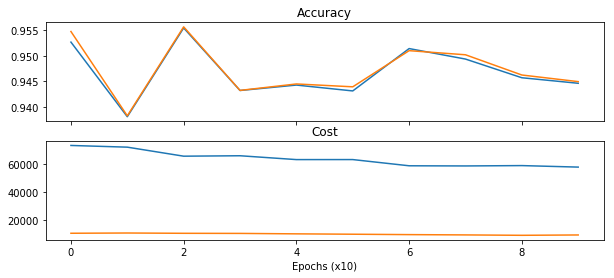

In [49]:
# Plot the accuracy and cost summaries 
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,4))

ax1.plot(accuracy_summary) # blue
ax1.plot(valid_accuracy_summary) # green
ax1.set_title('Accuracy')

ax2.plot(cost_summary)
ax2.plot(valid_cost_summary)
ax2.set_title('Cost')

plt.xlabel('Epochs (x10)')
plt.show()

In [50]:
# Find the predicted values, then use them to build a confusion matrix
predicted = tf.argmax(y, 1)
with tf.Session() as sess:  
    # Load the best weights
    saver.restore(sess, checkpoint)
    testing_predictions, testing_accuracy = sess.run([predicted, accuracy], 
                                                     feed_dict={x: inputX_test, y_:inputY_test, pkeep: 1})
    
    #print("F1-Score =", f1_score(inputY_test[:,1], testing_predictions))
    print("Testing Accuracy =", testing_accuracy)
    print()
    c = confusion_matrix(inputY_test[:,1], testing_predictions)
    
c

INFO:tensorflow:Restoring parameters from ./best_model.ckpt
Testing Accuracy = 0.942242



array([[   39,     2],
       [ 1643, 26797]], dtype=int64)

En moyenne, la matrice de confusion nous indique en général $\approx91\%$ de bonne classification pour les fraudes ($\pm5\%$ de marge d'erreur) et un peu moins de $98\%$ pour les transactions normales.

La précision générale est $\approx97.5\%$.

### Conclusion sur les choix de l'entrainement

Tout d'abord, nous nous demandons l'interêt de la banque sur l'efficacité de la classification.
- Est-ce que la banque souhaite détecter le plus de fraudes possible, quitte a avoir un nombre important de faux possitifs ?
- Est-ce que la banque cherche à limiter le nombre de faux possitif pour éviter de nuire aux actions des clients. De plus, si seulement $5\%$ des fraudes détéctées sont réellement des fraudes, la banque n'aura pas vraiment confiance aux résultats du classifieur. Ce que l'on a souvent pu observer avec une précision générale de $98\%$.

La suppression de certains attributs qui peuvent être associés à du bruit n'apporte pas d'amélioration significative dans la classification, par contre elle permet un entrainement plus rapide et nécéssitant moins d'epoch.
De plus, l'ajout des attributs générés $V_{x}\_$ améliore l'efficacité de la classification générale de $1\%$ mais rend l'entrainement beaucoup plus lent. Il en résulte la proportion de transactions normales détéctées en temps que fraude est réduite de moitiée. Ce qui est important puisque les transactions normales sont surreprésentées dans l'ensemble de données.


## Visualisation des données avec l'algorithme t-SNE

L'algorithme **t-SNE** (t-distributed Stochastic Neighbor Embedding) comme la **PCA** (Principal Component Analysis) permet de convertir un ensemble de points d'un espace originalement à haute dimension vers un espace de plus faible dimension, typiquement un plan en 2 dimensions, plus adapté à la visualisation des données. De plus il s'adapte aussi aux données utilisées grâce à des interprétations probabilistes des proximités et d'un nombre présumé de voisins donné en paramètre. La principale différence avec l'algorithme de PCA est que cette méthode est non linéaire. Ainsi cette méthode est souvent utilisée en machine learning car elle permet de visualiser ce qu'est capable d'interpréter le réseau de neurones : des groupes de points distincts sur un affichage de t-SNE sont potentiellment classifiable par le réseau de neurones.

Nous allons commencer par utiliser t-SNE pour visualiser les données non altérées (avec les attributs d'origine), puis nous ferons de même avec les données que nous avons avons modifiées (avec $39$ attributs). S'il y a un meilleur contraste entre les deux groupes de transactions sur le deuxième graphique, c'est que les opérations d'élimination d'attributs et autre modifications effectuées pour obtenir le deuxième set de données étaient pertinentes et auront aidé à simplifier l'apprentissage du réseau de neurones.

### Visualisation des données originales

In [51]:
# On charge à nouveau les données avec leur attributs de base
tsne_data = pd.read_csv("creditcard.csv")

In [52]:
# df2 contient toutes les données frauduleuses et 10 000 données normales 
# afin de ne pas alourdir l'affichage.
df2 = tsne_data[tsne_data.Class == 1]
df2 = pd.concat([df2, tsne_data[tsne_data.Class == 0].sample(n = 10000)], axis = 0)

In [53]:
# Effectue un changement d'échelle pour améliorer l'efficacité de l'entrainement
standard_scaler = StandardScaler()
df2_std = standard_scaler.fit_transform(df2)

y = df2.ix[:,-1].values

C:\Users\MiniKochi\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


In [54]:
tsne = TSNE(n_components=2, random_state=0)
x_test_2d = tsne.fit_transform(df2_std)

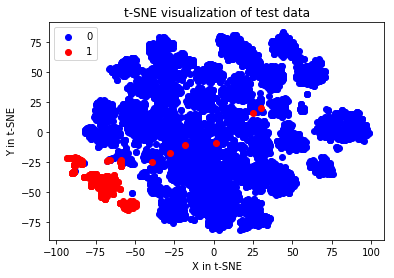

In [55]:
# dessine le graphique des données frauduleuses et non frauduleuses en 2D grâce a t-SNE
color_map = {1:'red', 0:'blue'}
plt.figure()
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x = x_test_2d[y==cl,0], 
                y = x_test_2d[y==cl,1], 
                c = color_map[idx], 
                label = cl)
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of test data')
plt.show()

Remarques:
- L'affichage de t-SNE varie à chaque utilisation, l'algorithme étant non déterministe.
- L'auteur n'a utilisé que $10\ 000$ des $284\ 315$ transactions normales pour cette visualisation afin de ne pas trop alourdir le graphique déjà bien chargé (il faut aussi que le pc le supporte). Si toutes les transactions étaient incluses il y aurait certainement des différences mais dans l'ensemble la représentation ne diffère pas trop.

### Visualisation des données modifiées

In [56]:
# df_used contient toutes les données frauduleuses et 10 000 données normales avec 39 attributs 
# Données modifés
df_used = Fraud
df_used = pd.concat([df_used, Normal.sample(n = 10000)], axis = 0)

In [57]:
df_used_std = standard_scaler.fit_transform(df_used)
y_used = df_used.ix[:,-1].values

C:\Users\MiniKochi\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [58]:
x_test_2d_used = tsne.fit_transform(df_used_std)

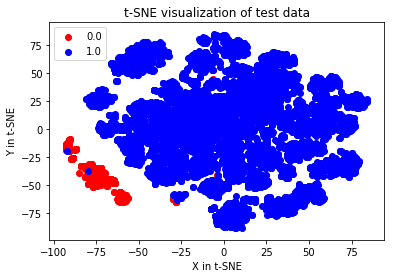

In [59]:
color_map = {0:'red', 1:'blue'}
plt.figure()
for idx, cl in enumerate(np.unique(y_used)):
    plt.scatter(x=x_test_2d_used[y_used==cl,0], 
                y=x_test_2d_used[y_used==cl,1], 
                c=color_map[idx], 
                label=cl)
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of test data')
plt.show()

Il semble que le travail effectué dans l'étape de modification des attributs était plutot cohérente. Nous constatons que les transactions frauduleuses font souvent partie d'un groupe de points unique. Cela peut suggèrer qu'il est sûrement plus facile pour notre réseau de neurones d'identifier les transactions frauduleuses parmi les données modifiées que parmi celles d'origine.